In [16]:
!pip -q install imbalanced-learn

# **1. Import Libraries**

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings

# **2. Load Dataset**

In [18]:
df = pd.read_csv('creditcard.csv')

In [19]:
display(df.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [20]:
df = df.dropna(subset=["Class"])
df = df.dropna()

In [21]:
print("Shape after dropping NaN:", df.shape)
print("NaNs per column:\n", df.isna().sum())

Shape after dropping NaN: (15935, 31)
NaNs per column:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


# **3. EDA**

In [22]:
print("\nClass distribution (counts):")
print(df['Class'].value_counts())
print("\nClass distribution (%):")
print((df['Class'].value_counts(normalize=True)*100).round(4))


Class distribution (counts):
Class
0.0    15862
1.0       73
Name: count, dtype: int64

Class distribution (%):
Class
0.0    99.5419
1.0     0.4581
Name: proportion, dtype: float64


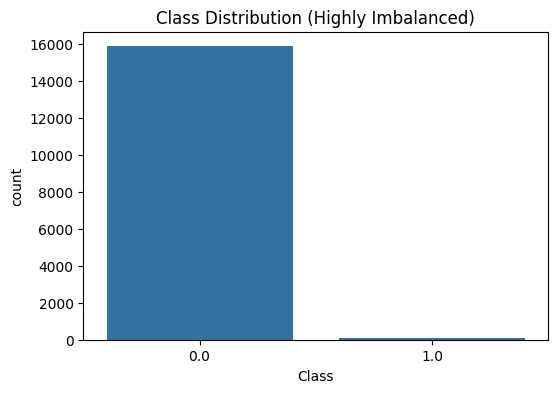

In [23]:
plt.figure(figsize=(6,4))
sns.countplot(x="Class", data=df)
plt.title("Class Distribution (Highly Imbalanced)")
plt.show()

# **4. Features / Target**

In [24]:
X = df.drop(columns=["Class"])
y = df["Class"]

# **5. Train/Test Split**

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [26]:
print("\nTrain/Test sizes:", X_train.shape, X_test.shape)


Train/Test sizes: (12748, 30) (3187, 30)


In [27]:
# Show effect of SMOTE on training set (for info only)
sm = SMOTE(random_state=42)
X_tmp, y_tmp = sm.fit_resample(X_train, y_train)
print("\nBefore SMOTE (train):")
print(y_train.value_counts())
print("\nAfter SMOTE (train):")
print(y_tmp.value_counts())


Before SMOTE (train):
Class
0.0    12690
1.0       58
Name: count, dtype: int64

After SMOTE (train):
Class
0.0    12690
1.0    12690
Name: count, dtype: int64


# **6. Define Pipelines**

In [28]:
# Logistic Regression Pipeline: Standardize -> SMOTE -> LogisticRegression
logreg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False)),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight=None,
        random_state=42
    ))
])

In [29]:
# RandomForest Pipeline
rf_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False)),
    ("smote", SMOTE(random_state=42)),
    ("clf", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    ))
])

In [30]:
models = {
    "Logistic Regression": logreg_pipeline,
    "Random Forest": rf_pipeline
}

# **7. Cross-Validation with StratifiedKFold (ROC-AUC)**

In [31]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

In [32]:
for name, pipe in models.items():
    scores = cross_val_score(
        pipe, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1
    )
    print(f"{name}: AUC-ROC mean={scores.mean():.4f} ± {scores.std():.4f}")
    cv_results.append({"Model": name, "CV ROC-AUC Mean": scores.mean(), "CV ROC-AUC Std": scores.std()})

cv_df = pd.DataFrame(cv_results)
display(cv_df)

Logistic Regression: AUC-ROC mean=0.9689 ± 0.0300
Random Forest: AUC-ROC mean=0.9816 ± 0.0225


,Model,CV ROC-AUC Mean,CV ROC-AUC Std
0,Logistic Regression,0.968882,0.029966
1,Random Forest,0.981573,0.022541


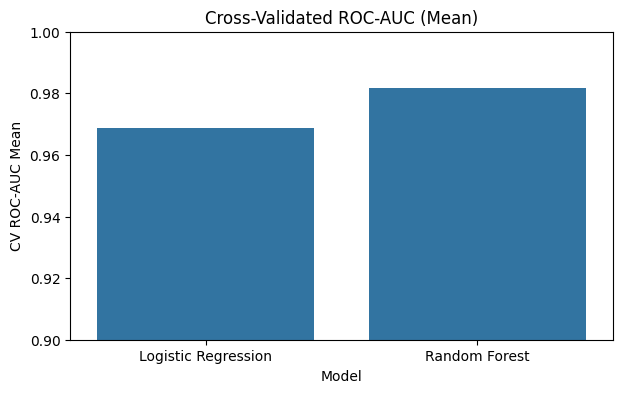

In [33]:
plt.figure(figsize=(7,4))
sns.barplot(data=cv_df, x="Model", y="CV ROC-AUC Mean")
plt.title("Cross-Validated ROC-AUC (Mean)")
plt.ylim(0.9, 1)
plt.show()

# **8. Fit on Train, Evaluate on Test**

In [34]:
def evaluate_model(name, pipeline, X_train, y_train, X_test, y_test):
    print(f"\n===== {name} | Test Evaluation =====")
    pipeline.fit(X_train, y_train)
    # Probabilities for positive class
    if hasattr(pipeline.named_steps["clf"], "predict_proba"):
        y_proba = pipeline.predict_proba(X_test)[:, 1]
    else:
        y_scores = pipeline.decision_function(X_test)
        # min-max to pseudo prob
        y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min() + 1e-9)

    # Default threshold 0.5
    y_pred = (y_proba >= 0.5).astype(int)

    # Metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, digits=4, target_names=["Legit", "Fraud"])
    print("ROC-AUC:", round(roc_auc, 4))
    print("\nClassification Report:\n", report)

    # Confusion Matrix plot
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

    # Precision-Recall Curve + AUC
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label=f"{name} (PR AUC={pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {name}")
    plt.legend()
    plt.show()

    return {
        "Model": name,
        "Test ROC-AUC": roc_auc,
        "Test PR-AUC": pr_auc,
        "ConfusionMatrix": cm
    }


===== Logistic Regression | Test Evaluation =====
ROC-AUC: 0.987

Classification Report:
               precision    recall  f1-score   support

       Legit     0.9987    0.9937    0.9962      3172
       Fraud     0.3548    0.7333    0.4783        15

    accuracy                         0.9925      3187
   macro avg     0.6768    0.8635    0.7372      3187
weighted avg     0.9957    0.9925    0.9938      3187



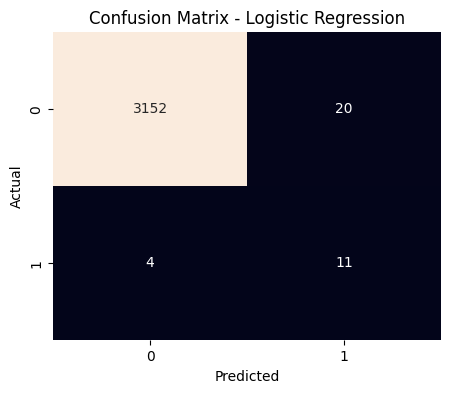

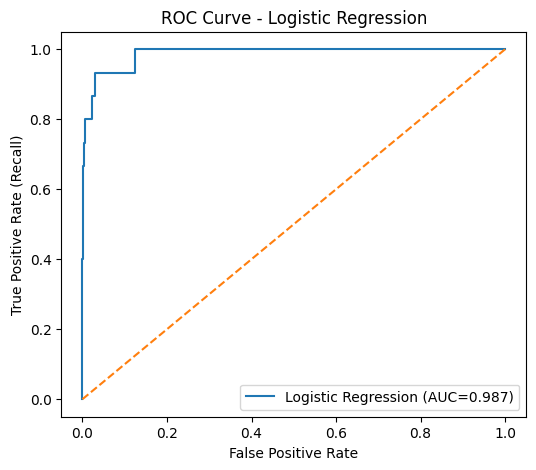

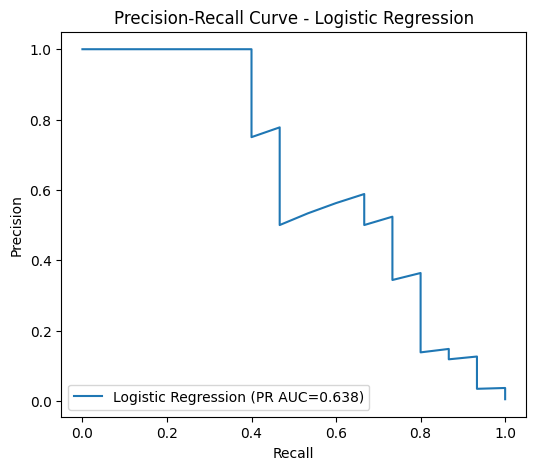


===== Random Forest | Test Evaluation =====
ROC-AUC: 0.9611

Classification Report:
               precision    recall  f1-score   support

       Legit     0.9991    0.9991    0.9991      3172
       Fraud     0.8000    0.8000    0.8000        15

    accuracy                         0.9981      3187
   macro avg     0.8995    0.8995    0.8995      3187
weighted avg     0.9981    0.9981    0.9981      3187



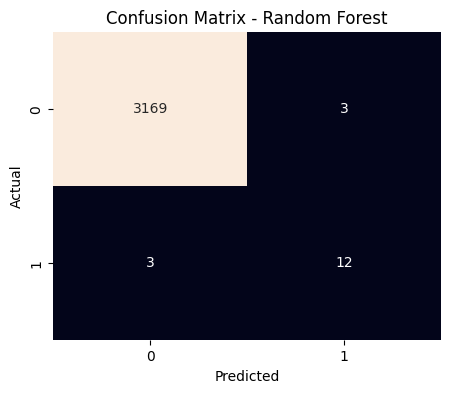

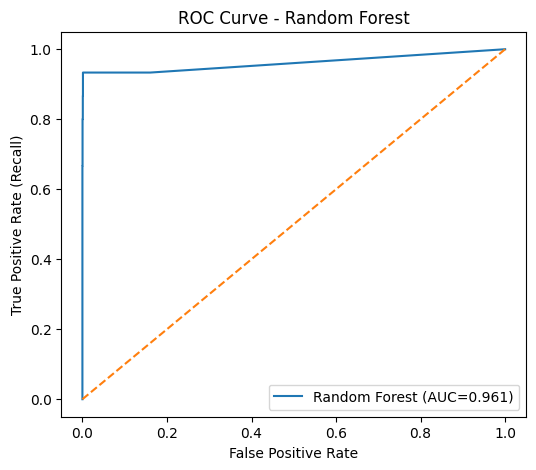

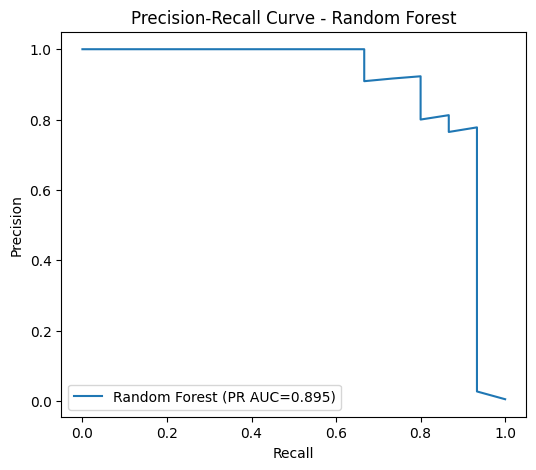

In [35]:
test_results = []
for name, pipe in models.items():
    res = evaluate_model(name, pipe, X_train, y_train, X_test, y_test)
    test_results.append(res)

# **9. Compare Test ROC-AUC / PR-AUC**

In [36]:
cmp_df = pd.DataFrame([
    {"Model": r["Model"], "Test ROC-AUC": r["Test ROC-AUC"], "Test PR-AUC": r["Test PR-AUC"]}
    for r in test_results
])
display(cmp_df)

,Model,Test ROC-AUC,Test PR-AUC
0,Logistic Regression,0.986969,0.637994
1,Random Forest,0.961129,0.895065


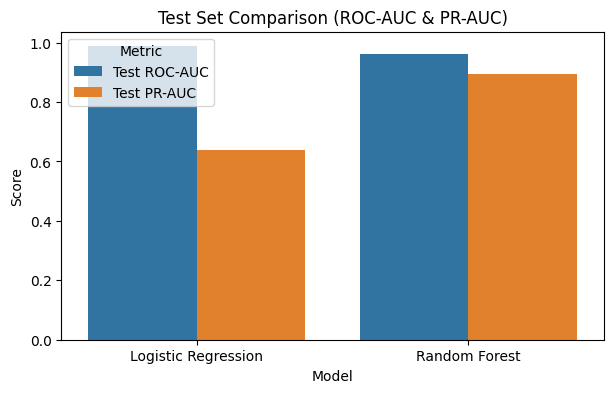

In [37]:
plt.figure(figsize=(7,4))
sns.barplot(data=cmp_df.melt(id_vars="Model", var_name="Metric", value_name="Score"),
            x="Model", y="Score", hue="Metric")
plt.title("Test Set Comparison (ROC-AUC & PR-AUC)")
plt.show()

# **10. Feature Importance (Random Forest)**

In [38]:
rf_pipeline.fit(X_train, y_train)
rf_clf = rf_pipeline.named_steps["clf"]
feature_names = X_train.columns
importances = getattr(rf_clf, "feature_importances_", None)

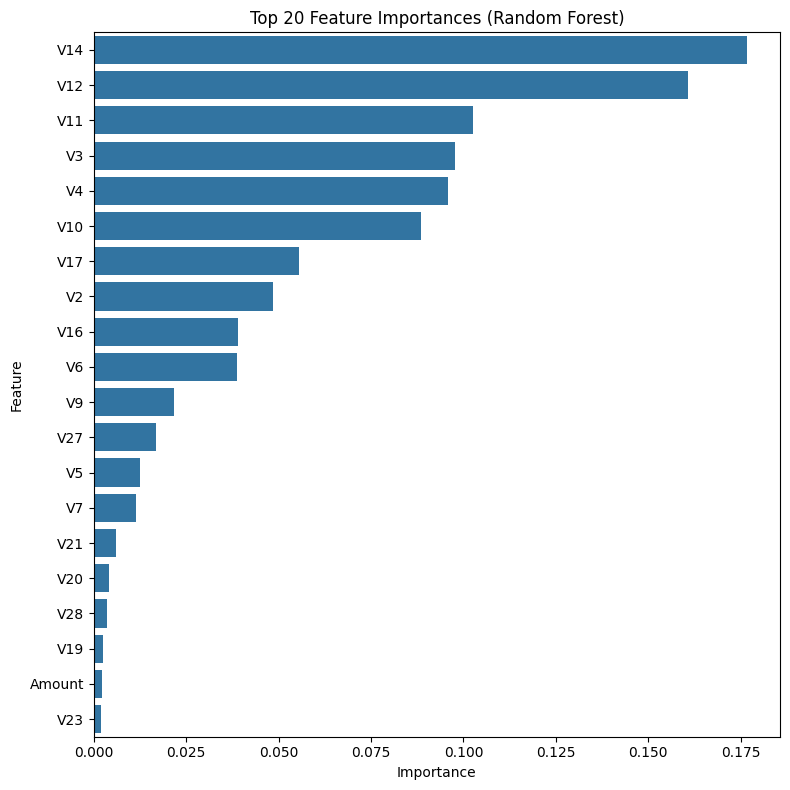

In [39]:
if importances is not None:
    imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,8))
    sns.barplot(x=imp.values, y=imp.index)
    plt.title("Top 20 Feature Importances (Random Forest)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances not available for this classifier.")